# Modelling Section

**Welcome to modelling section!**

This is the second notebook for **the scraped Apartment dataset**. Here, we will **create and evaluate** some **models** from the data that have been cleaned before to **predict the price** and **find out** the things that have **the most important variable** to the model

**1. What models will be tested ?**
- XGBoost
- LightGBM
- NGBoost
- Catboost
- Blended *( XGBoost tuned, LightGMB ver.1, LightGBM tuned, NGBoost )*

**2. What parameters to evaluate them?**

a. *MSE ( Mean Squared Error )*
 

Average of the square of the difference between actual and estimated values

b. *RMSE ( Root Mean Squared Error )*

Basically, this value got from square root of average error. It can a be parameter to compare the models with each other and **I would use** this to **identify** if the model is more **over/underfitting** than the others.

c. *R2 ( R-Squared )*

The proportion of the variance in the dependent variable that is predictable from the independent variable

d. *MAE ( Mean Absolute Error )*

Average of the absolute values of the difference between actual and estimated values

------------------------------------------------------------------------

For some reasons, We will only evaluate the models with RMSE and check the accuracy using R2 score in the last section

***After testing the models one by one in baseline mode, I'm gonna do hyperparameter tuning and would be compare it with the baseline model***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.pyplot import rcParams
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns',100)
rcParams['figure.figsize'] = (15,5)
rcParams['axes.grid'] = True
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
plt.rc('axes',axisbelow=True)

In [3]:
df = pd.read_csv('D:/Data/apartment/fr/cleaned_1.csv').drop(['full_apartment_name','link','unit_name','region'],axis=1)
df=df[df.annual_price<6e8]
df.sample(2)

,room,bathroom,Furnished,Area,annual_price,atm,basketball_court,cable_tv,function_room,grocery_store,gym,internet,jogging_track,swimming_pool,tennis_court,laundry,restaurant,security,playground,ac,access_card,water_heater,washing_machine,kitchen,dining_set,fridge,bed,tv,Latitude,Longitude
5892,2 BR,1,Non Furnished,37.21,54600000.0,0,0,1,1,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,-6.170200,106.6403
3358,1 BR,1,Fully Furnished,37.00,65000000.0,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,-6.225014,106.9004


In [4]:
df.shape

(7290, 30)

**Interesting! From 7452 to 7290 raws. We only remove 2% of data**

In [5]:
df.replace({'room':{'BR':'','Studio':0},
           },regex=True,inplace=True)

In [6]:
df_new = pd.concat([df,pd.get_dummies(df['Furnished'])],axis=1).drop('Furnished',axis=1)
df_new['room'] = df_new.room.astype(int)
df_new.head()

,room,bathroom,Area,annual_price,atm,basketball_court,cable_tv,function_room,grocery_store,gym,internet,jogging_track,swimming_pool,tennis_court,laundry,restaurant,security,playground,ac,access_card,water_heater,washing_machine,kitchen,dining_set,fridge,bed,tv,Latitude,Longitude,Fully Furnished,Non Furnished,Semi Furnished
0,1,1,42.0,90000000.0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,-6.180500,106.8284,1,0,0
1,1,1,35.0,44000000.0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,-6.167400,106.7637,0,1,0
2,2,1,54.0,70000000.0,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,-6.225014,106.9004,1,0,0
3,0,1,24.0,25000000.0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,-6.167400,106.7637,1,0,0
4,0,1,26.0,24000000.0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,-6.167400,106.7637,0,0,1


# Understand the data

### Normality

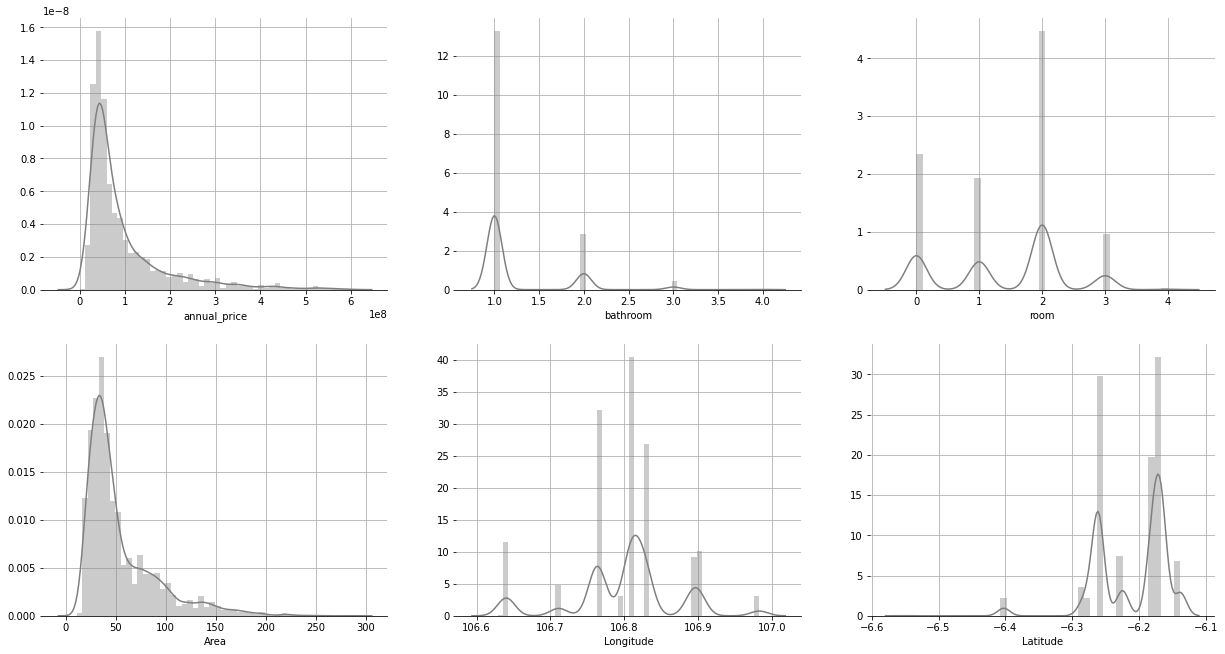

In [7]:
plt.figure(figsize=(21,11))
num = ['annual_price','bathroom','room','Area','Longitude','Latitude']
for i in range(len(df_new[num].columns)):
    plt.subplot(2,len(df_new[num].columns)/2,i+1)
    sns.distplot(df_new[num[i]],color='tab:grey')
    plt.ylabel('') 

Let's transform some of them for better distribution

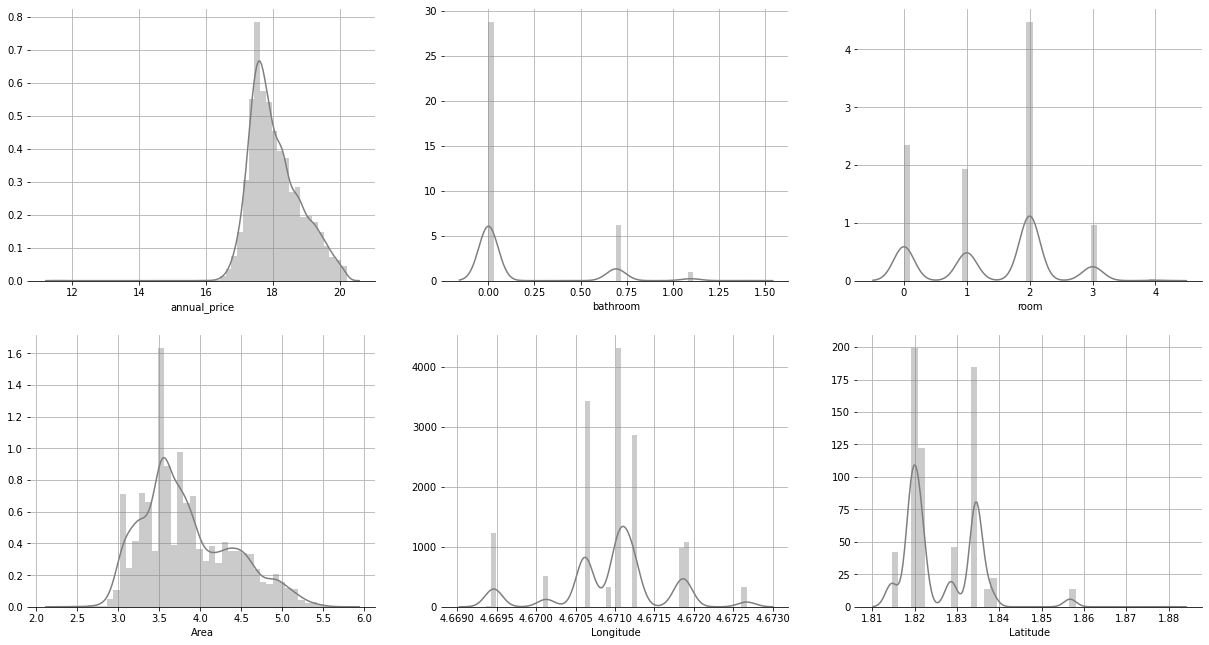

In [8]:
from scipy.stats import boxcox

plt.figure(figsize=(21,11))

df2 = df_new.copy()
df2['annual_price']= np.log(df2.annual_price)
df2['Area'] = np.log(df2.Area)
df2['bathroom'] = np.log(df2.bathroom)
df2['Longitude'] = np.log(df2.Longitude)
df2['Latitude'] = np.log(np.abs(df2.Latitude))

for i in range(len(df2[num].columns)):
    plt.subplot(2,len(df2[num].columns)/2,i+1)
    sns.distplot(df2[num[i]],color='tab:grey')
    plt.ylabel('') 

In [9]:
df2[num].skew()

annual_price    0.557505
bathroom        1.710768
room           -0.205690
Area            0.622418
Longitude      -0.365893
Latitude        1.038631
dtype: float64

Looks better

## Correlation

In [10]:
corr = df2.corr().drop(columns='annual_price',errors='ignore')

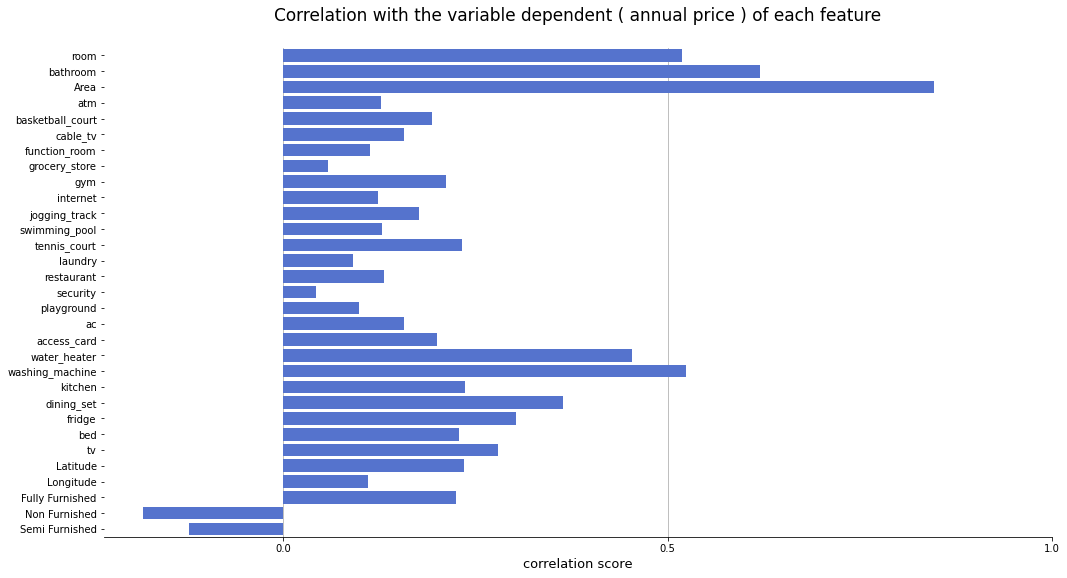

In [11]:
plt.figure(figsize=(17,9))
sns.barplot(y=corr.loc['annual_price'].index,x=corr.loc['annual_price'],color='royalblue')
plt.title('Correlation with the variable dependent ( annual price ) of each feature\n',size=17)
plt.xlabel('correlation score',size=13)
plt.xticks([0,5e-1,10e-1])
plt.show()

There are **four features** that have correlation score more than **0.5** with ***the annual rent price***. Those are *Washing Machine*, *Room*, *Area*, and *Bathroom*

Since we won't do the modelling with **Linear Regression**, using **tree-based** instead, we'll keep all of them for now

In [12]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Split and Create a function for evaluating the models

Splitting the data into train and test set. We will put 20% of that into test set and the rest into training set

In [13]:
X = df2.drop('annual_price',axis=1)
y = df2.annual_price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [14]:
def evaluate(model, return_val = False):
   
    print('MAE:', mean_absolute_error(test_val, prediction))
    print('MSE:', mean_squared_error(test_val, prediction))
    print('RMSE train:', np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
    print('RMSE test :', np.sqrt(mean_squared_error(test_val, prediction)))
    print('R2 Score:', r2_score(test_val, prediction))
    print('Adjusted R2 Score:', 1-(1-r2_score(test_val, prediction))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

def scores(model, name):
    test_val = y_test.values.tolist()
    prediction = model.predict(X_test)    
        
    sns.scatterplot(test_val, prediction)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    score = pd.Series({'Model':name,
              'RMSE_train': mean_squared_error(y_train, model.predict(X_train)),
              'RMSE_test': mean_squared_error(y_test, model.predict(X_test)),
              'R2_train': r2_score(y_train, model.predict(X_train)),
              'R2_test': r2_score(y_test, model.predict(X_test))
             })
    return score

# Modelling

## XGBoost

XGBoost is a gradient boosted decision trees algorithm which has dominated Kaggle in recent years. Unlike Linear Regression, it does not have to be scaled, and it can handle multicolinearity better since by its nature, decision trees are immune to multicolinearity. However, it will not yield an outcome which can be interpreted as clear as Linear Regression. It doesn't have any explicit coefficient which can further be tested with t-test and calculate it's p-value

### Baseline model ( First version )

In [15]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Model         XGB_ver1
RMSE_train    0.028326
RMSE_test      0.06101
R2_train      0.948711
R2_test       0.890778
dtype: object

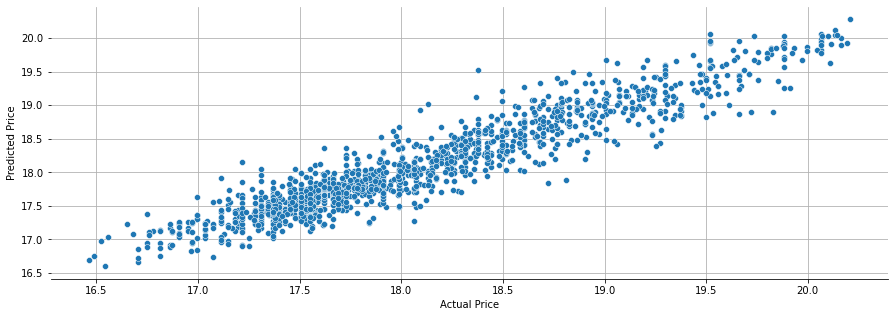

In [16]:
# Store values
xgb1_df = scores(xgb,'XGB_ver1')
xgb1_df 

When our baseline model is used to predict the training set, the RMSE is 0.028. However, when it is used to predict the testing set, its rmse is about 0.061. This shows that there might be an overfitting issue.

Now we are given two options. We can stop at this stage, and accept that our model or we can try to make it less overfit. Both are actually acceptable, as the testing R-squared score has already reached 89% ( eaning that our model are also capable in predicting 'unseen' data points ).

We will try to do some hyperparameter tuning to solve this overfitting issue, and see where it leads us to.

### Hyperparameter tuning ( Second version )

In [17]:
params1 = {'learning_rate':[x for x in np.arange(0.01,0.1,0.02)],
          'n_estimators' :[j for j in range(80,100)],
          'max_depth':[a for a in range(1,8)],
          'min_child_weight':[b for b in range(1,9)],    
          'gamma': np.arange(0.1, 1.1),
          "reg_alpha": [m for m in np.arange(0.1, 0.7,0.09)],
           'scale_pos_weight':[13.92,14],
           'objective':['reg:squarederror','reg:linear'],
           'booster':['gbtree','gblinear','dart']
         }

In [18]:
skf = KFold(3,shuffle=True,random_state=42)

In [19]:
xgb1 = XGBRegressor()
rsc = RandomizedSearchCV(xgb1,params1,cv=skf.get_n_splits(X,y),n_jobs=-1,verbose=1,random_state=101)
rsc.fit(X_train,y_train)

print(rsc.score(X_test,y_test))
print(rsc.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[15:12:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
0.882272623305565
{'scale_pos_weight': 13.92, 'reg_alpha': 0.5499999999999999, 'objective': 'reg:linear', 'n_estimators': 88, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.08999999999999998, 'gamma': 0.1, 'booster': 'gbtree'}


In [20]:
xgb1 = XGBRegressor(**(rsc.best_params_))
xgb1.fit(X_train,y_train)

[15:12:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08999999999999998,
             max_delta_step=0, max_depth=7, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=88, n_jobs=2,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0.5499999999999999, reg_lambda=1,
             scale_pos_weight=13.92, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Model         XGB_ver2
RMSE_train    0.054452
RMSE_test     0.065761
R2_train      0.901404
R2_test       0.882273
dtype: object


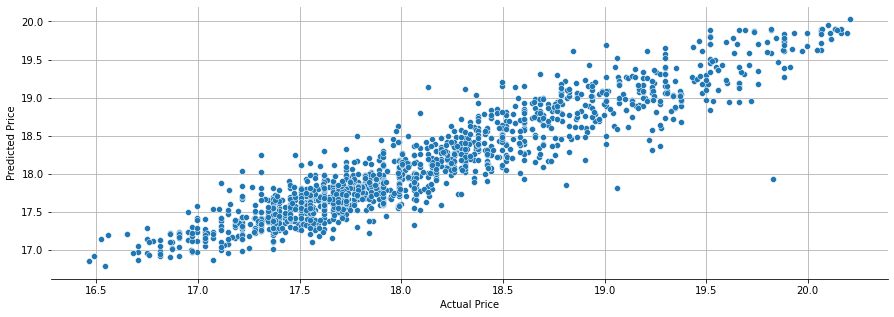

In [21]:
xgb2_df = scores(xgb1,'XGB_ver2')
print(xgb2_df)
score = pd.concat([xgb1_df,xgb2_df],axis=1)

### Parameters from other resource ( Third version )

I got this parameters from someone in Kaggle ( I've changed some parametes to suit with our data ). The problem is also about Predicting Prices ( Houses case ). Thus, we'll try it since the result that she got is satisfying

In [22]:
xgb2 = XGBRegressor(learning_rate=0.1,n_estimators=3000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)
xgb2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.6, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=0, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=2, nthread=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

Model         XGB_ver3
RMSE_train    0.055316
RMSE_test     0.063584
R2_train      0.899839
R2_test       0.886169
dtype: object


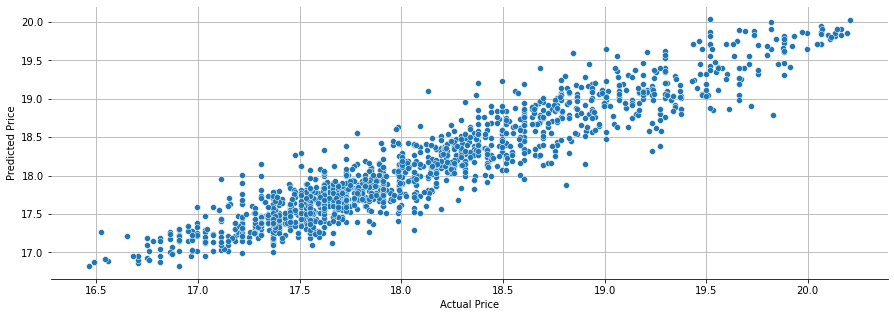

In [23]:
xgb3_df = scores(xgb2,'XGB_ver3')
print(xgb3_df)
score = pd.concat([score,xgb3_df],axis=1).T.drop_duplicates().T

In [24]:
score.columns = score.iloc[0]
score.iloc[1:]

Model,XGB_ver1,XGB_ver2,XGB_ver3
RMSE_train,0.028326,0.054452,0.055316
RMSE_test,0.06101,0.065761,0.063584
R2_train,0.948711,0.901404,0.899839
R2_test,0.890778,0.882273,0.886169


**Interesting!** We got the smallest RMSE test in XGB version 1 ( baseline model ), also the highest R2 test score. But, the problem is, this model is more overfitting than the others

## LightGBM

### Baseline model ( Version 1 )

In [25]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor()
lgb.fit(X_train, y_train)

LGBMRegressor()

Model         LGB_ver1
RMSE_train    0.055185
RMSE_test     0.062375
R2_train      0.900076
R2_test       0.888334
dtype: object


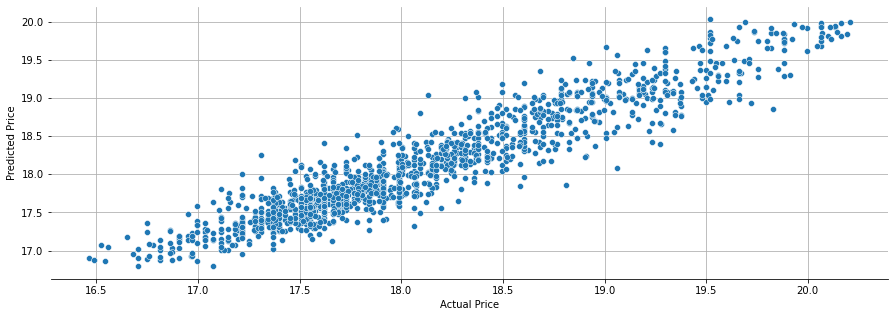

In [26]:
lgb1_df = scores(lgb,'LGB_ver1')
print(lgb1_df)
score = pd.concat([score,lgb1_df],axis=1)

### Hyperparameter tuning ( Version 2 )

In [27]:
gparams = {'learning_rate':[x for x in np.arange(0.05,0.5,0.05)],
          'n_estimators' :[j for j in range(80,100)],
          'max_depth':[a for a in range(1,8)],
          'min_child_weight':[b for b in range(1,9)],    
          'gamma': range(1, 9),
          "reg_alpha": [m for m in np.arange(0.1, 0.7,0.09)],
           'scale_pos_weight':[13.92,14]
         }

gparams1 = {'learning_rate':[x for x in np.arange(0.01,0.1,0.02)],
          'n_estimators' :[j for j in range(80,100)],
          'max_depth':[a for a in range(1,8)],
          'min_child_weight':[b for b in range(1,9)],    
          'gamma': np.arange(0.1, 1.1),
          "reg_alpha": [m for m in np.arange(0.1, 0.7,0.09)],
           'scale_pos_weight':[13.92,14],
           'booster':['gbtree','gblinear','dart']
           }

In [28]:
lgb1 = LGBMRegressor()
rsc1 = RandomizedSearchCV(lgb1,gparams1,cv=skf.get_n_splits(X,y),verbose=1,n_jobs=-1)
rsc1.fit(X_train,y_train)

print(rsc1.score(X_test,y_test))
print(rsc1.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
0.8837541192498233
{'scale_pos_weight': 13.92, 'reg_alpha': 0.19, 'n_estimators': 93, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.08999999999999998, 'gamma': 0.1, 'booster': 'gblinear'}


In [29]:
lgb1 = LGBMRegressor(**{'scale_pos_weight': 14, 'reg_alpha': 0.1, 'n_estimators': 99, 'min_child_weight': 8, 'max_depth': 6, 'learning_rate': 0.08999999999999998, 'gamma': 0.1, 'booster': 'dart'})
lgb1.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster


LGBMRegressor(booster='dart', gamma=0.1, learning_rate=0.08999999999999998,
              max_depth=6, min_child_weight=8, n_estimators=99, reg_alpha=0.1,
              scale_pos_weight=14)

Model         LGB_ver2
RMSE_train     0.06229
RMSE_test      0.06441
R2_train      0.887211
R2_test       0.884691
dtype: object


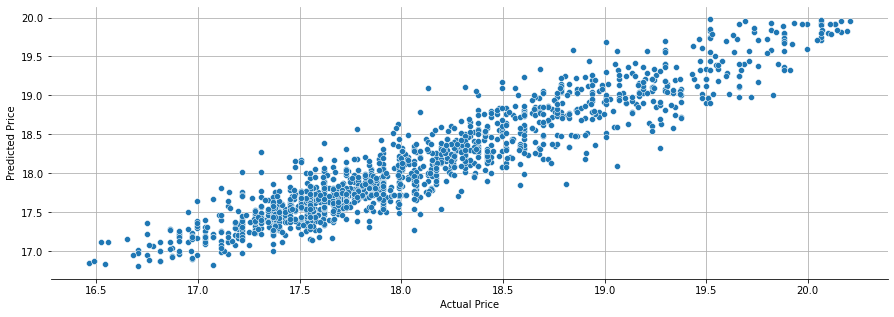

In [30]:
lgb2_df = scores(lgb1,'LGB_ver2')
print(lgb2_df)
score = pd.concat([score, lgb2_df],axis=1)

In [31]:
score

,XGB_ver1,XGB_ver2,XGB_ver3,0,0
Model,XGB_ver1,XGB_ver2,XGB_ver3,LGB_ver1,LGB_ver2
RMSE_train,0.028326,0.054452,0.055316,0.055185,0.06229
RMSE_test,0.06101,0.065761,0.063584,0.062375,0.06441
R2_train,0.948711,0.901404,0.899839,0.900076,0.887211
R2_test,0.890778,0.882273,0.886169,0.888334,0.884691


## Catboost

### Baseline model ( Version 1 )

In [32]:
from catboost import CatBoostRegressor
cb = CatBoostRegressor()
cb.fit(X_train, y_train,verbose=1000)

Learning rate set to 0.054098
0:	learn: 0.7143647	total: 183ms	remaining: 3m 2s
999:	learn: 0.2047537	total: 5.2s	remaining: 0us


Model         CatBoost_ver1
RMSE_train         0.041924
RMSE_test          0.058308
R2_train           0.924088
R2_test            0.895614
dtype: object


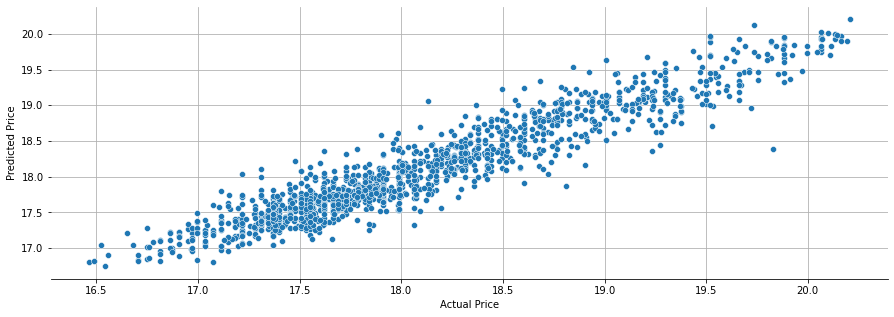

In [33]:
cb1_df = scores(cb, 'CatBoost_ver1')
print(cb1_df)
score = pd.concat([score, cb1_df],axis=1)

### From other resource ( Version 2 )

In [34]:
cb1 = CatBoostRegressor(loss_function='RMSE',
                       learning_rate=0.005, 
                       n_estimators=4000,
                       max_bin=200,
                       verbose=500)
cb1.fit(X_train, y_train)

0:	learn: 0.7404808	total: 3.38ms	remaining: 13.5s
500:	learn: 0.3120556	total: 1.99s	remaining: 13.9s
1000:	learn: 0.2780546	total: 3.82s	remaining: 11.5s
1500:	learn: 0.2651967	total: 5.55s	remaining: 9.23s
2000:	learn: 0.2570254	total: 7.24s	remaining: 7.23s
2500:	learn: 0.2507645	total: 8.88s	remaining: 5.32s
3000:	learn: 0.2452240	total: 10.5s	remaining: 3.49s
3500:	learn: 0.2402532	total: 12.1s	remaining: 1.73s
3999:	learn: 0.2362802	total: 13.9s	remaining: 0us


Model         CatBoost_ver2
RMSE_train         0.055828
RMSE_test           0.06275
R2_train           0.898912
R2_test            0.887663
dtype: object


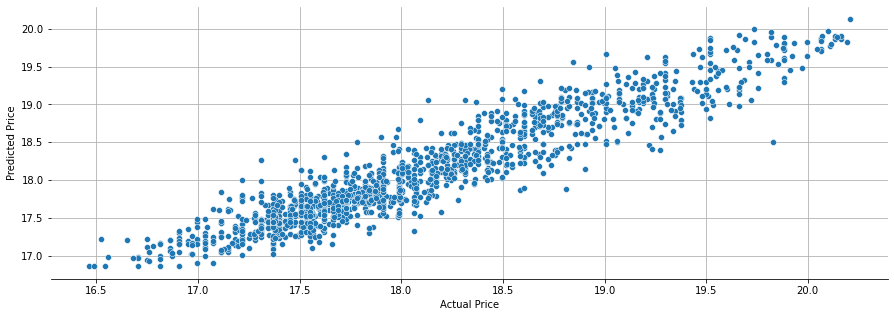

In [35]:
cb2_df = scores(cb1, 'CatBoost_ver2')
print(cb2_df)
score = pd.concat([score, cb2_df],axis=1)

In [36]:
score

,XGB_ver1,XGB_ver2,XGB_ver3,0,0,0,0
Model,XGB_ver1,XGB_ver2,XGB_ver3,LGB_ver1,LGB_ver2,CatBoost_ver1,CatBoost_ver2
RMSE_train,0.028326,0.054452,0.055316,0.055185,0.06229,0.041924,0.055828
RMSE_test,0.06101,0.065761,0.063584,0.062375,0.06441,0.058308,0.06275
R2_train,0.948711,0.901404,0.899839,0.900076,0.887211,0.924088,0.898912
R2_test,0.890778,0.882273,0.886169,0.888334,0.884691,0.895614,0.887663


### NGBoost

In [37]:
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.tree import DecisionTreeRegressor

In [38]:
ngb = NGBoost(Base=default_tree_learner, Dist=Normal,Score=MLE, natural_gradient=True,verbose=False,learning_rate=0.01,verbose_eval='neg_mean_squared_error')
ngb.fit(X_train,y_train)

Model          NGBoost
RMSE_train    0.075603
RMSE_test     0.075842
R2_train      0.863106
R2_test       0.864224
dtype: object


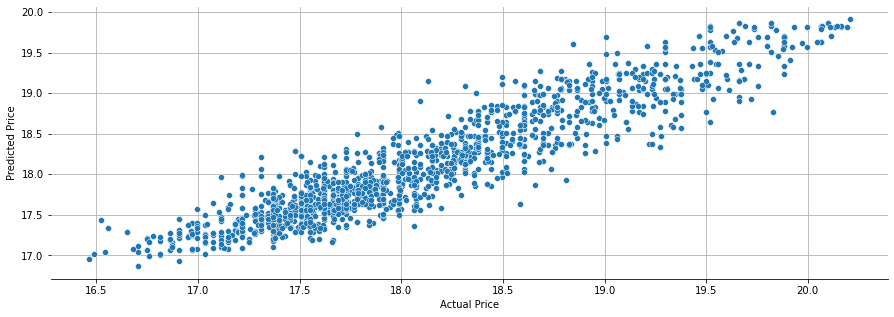

In [39]:
ngb_df = scores(ngb, 'NGBoost')
print(ngb_df)
score = pd.concat([score, ngb_df],axis=1)

## Blended Version

In [145]:
score.columns = score.iloc[0]
score

Model,XGB_ver1,XGB_ver2,XGB_ver3,LGB_ver1,LGB_ver2,CatBoost_ver1,CatBoost_ver2,NGBoost
Model,XGB_ver1,XGB_ver2,XGB_ver3,LGB_ver1,LGB_ver2,CatBoost_ver1,CatBoost_ver2,NGBoost
RMSE_train,0.028326,0.054452,0.055316,0.055185,0.06229,0.041924,0.055828,0.075603
RMSE_test,0.06101,0.065761,0.063584,0.062375,0.06441,0.058308,0.06275,0.075842
R2_train,0.948711,0.901404,0.899839,0.900076,0.887211,0.924088,0.898912,0.863106
R2_test,0.890778,0.882273,0.886169,0.888334,0.884691,0.895614,0.887663,0.864224


In [41]:
def blended_predictions(X):
    return ((0.2*xgb.predict(X))+\
            (0.3 * lgb.predict(X)) + \
            (0.3 * lgb1.predict(X)) + \
            (0.1 * cb.predict(X))+\
            (0.1*cb1.predict(X))+\
            (0.0*ngb.predict(X))
           )

In [42]:
print(mean_squared_error(y_train, blended_predictions(X_train)))
print(mean_squared_error(y_test, blended_predictions(X_test)))
print(r2_score(y_train, blended_predictions(X_train)))
print(r2_score(y_test, blended_predictions(X_test)))

0.04651663677736368
0.05939548780060925
0.9157725153754658
0.8936679900411455


In [43]:
def blended_predictions(X):
    return ((0.2 *xgb.predict(X))+\
            (0.2 * lgb.predict(X)) + \
            (0.2 * lgb1.predict(X)) + \
            (0.4 * cb.predict(X)))
            # (0.2* cb1.predict(X)))

In [44]:
print(mean_squared_error(y_train, blended_predictions(X_train)))
print(mean_squared_error(y_test, blended_predictions(X_test)))
print(r2_score(y_train, blended_predictions(X_train)))
print(r2_score(y_test, blended_predictions(X_test)))

0.04204350317532749
0.05803108024021346
0.9238720001574854
0.8961106031700582


# Residual Plot

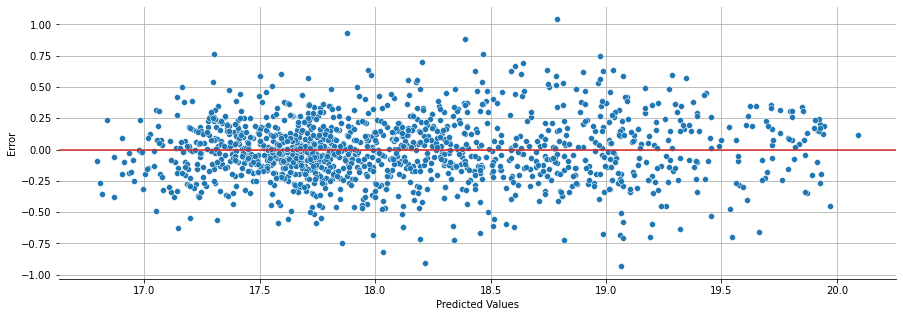

In [149]:
res = y_test - blended_predictions(X_test)
plt.axhline(color='tab:red')
sns.scatterplot(blended_predictions(X_test), res)
plt.ylabel('Error')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
models = []
models.append(('XGB', XGBRegressor()))
models.append(('XGB1', XGBRegressor(learning_rate=0.1,n_estimators=3000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)))
models.append(('XGB2', XGBRegressor(**rsc.best_params_)))
models.append(('LGB', LGBMRegressor()))
models.append(('LGB1', LGBMRegressor(**rsc1.best_params_)))
models.append(('CB', CatBoostRegressor()))
models.append(('CB1', CatBoostRegressor(loss_function='RMSE',
                       learning_rate=0.005, 
                       n_estimators=4000,
                       max_bin=200,
                       verbose=500)))

# evaluate each model in turning kfold results
results_boxplot = []
names = []
results_mean = []
results_std = []
p,t = X.values, y.values.ravel()
for name, model in models:
    cv_results = cross_val_score(model, p,t, cv=10)
    results_boxplot.append(cv_results)
    results_mean.append(cv_results.mean())
    results_std.append(cv_results.std())
    names.append(name)
pd.DataFrame({"Algorithm":names,
                                "Accuracy Mean":results_mean,
                                "Accuracy":results_std})

[16:26:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:18

,Algorithm,Accuracy Mean,Accuracy
0,XGB,0.850016,0.021665
1,XGB1,0.844946,0.020082
2,XGB2,0.841633,0.022708
3,LGB,0.846798,0.019580
4,LGB1,0.842005,0.019324
5,CB,0.852483,0.019184
6,CB1,0.843039,0.020150


In [150]:
20599123/30415774

0.677251317030433